# **SR-GaN**

In this notebook we are going to give a brief contextual explanation of SR-GANs and a basic way to implement it with pytorch

Author:  
@jwpr-dpr  
14/04/2025

## **Introduction to SRGAN**

### What is Super-Resolution?
Super-resolution (SR) is the task of enhancing the resolution of an image — in other words, generating a high-resolution (HR) image from a low-resolution (LR) input. This technique is especially useful in fields where image clarity matters but high-resolution data is costly or limited, such as:

* 📸 Photography (zoom enhancement)
* 🛰️ Satellite and remote sensing
* 🧬 Medical imaging (MRI, CT scans)
* 📹 Video frame enhancement
* 🔍 Forensics and surveillance

Classical approaches rely on interpolation (e.g., bicubic), or CNN-based models that minimize pixel-wise differences (like MSE). However, these often produce over-smoothed results that lack realistic textures.
### Why Use GANs?
Classical super-resolution models optimize for pixel-wise similarity (like MSE or PSNR), which leads to blurry results. SRGAN, or Super-Resolution Generative Adversarial Network, introduced by Ledig et al. (2017), takes a different approach. Generative Adversarial Networks (GANs) introduced a breakthrough in generating more visually pleasing, realistic images by framing the problem as a game between two networks:

* 🧠 Generator (G) learns to create high-resolution images from low-resolution inputs.
* 👀 Discriminator (D) tries to distinguish between generated images and real high-resolution ones.

The generator is trained not just to fool the discriminator, but also to minimize a perceptual loss, which compares high-level features extracted from a pretrained VGG network. This encourages photorealistic textures, not just pixel-level similarity. As a result, SRGANs generate sharper, more visually appealing results — even when they differ slightly from the original HR image in pixel values.

## **Dependencies & Setup**

All of this project is developed in Python, using pytorch. So all the dependencies, classes, functions and programming logic, derives from the used in this framework.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

Setting up the devices configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Also, we set variables for all of our needed folders

In [3]:
DATA_DIR = "../data"
RESULTS_DIR = "../test"
MODEL_DIR = "../models"

## **Dataset Preparation**

For training a Super-Resolution model, we need pairs of:

* Low-resolution (LR) images: downsampled versions
* High-resolution (HR) images: ground truth targets

To simulate real-world data, we’ll:

* Use high-quality images as HR
* Downscale them to generate corresponding LR images

First, let's have a simple example dataset

In [4]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

dataset = CIFAR10(root=DATA_DIR, download=True, transform=ToTensor())

Second, let's create a custom pytorch dataset designed for the kind of training that we are executing. This one will load HR images and generate LR images by resizing them. This is the most common procedure, in the case of our project, we will do something more interesting, instead of downgrading images, we will upgrade images with some transformations using openCV (read 09-ImageProcessing.ipynb), and the original images, will be the low resolution ones. But for now, let's stick to the common way 

In [5]:
class SRDataset(Dataset):
    def __init__(self, dataset, hr_size=96, upscale_factor=4):
        super().__init__()
        self.dataset = dataset
        self.hr_size = hr_size
        self.lr_size = hr_size // upscale_factor
        self.hr_transform = transforms.Compose([
            transforms.Resize((hr_size, hr_size), interpolation=Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((self.lr_size, self.lr_size), interpolation=Image.BICUBIC),
            transforms.Resize((hr_size, hr_size), interpolation=Image.BICUBIC),  # for comparison
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        img = transforms.ToPILImage()(img)
        hr = self.hr_transform(img)
        lr = self.lr_transform(img)
        return {"lr": lr, "hr": hr}


Then, we create our dataloaders

In [6]:
BATCH_SIZE = 16
HR_SIZE = 96
UPSCALE = 4

sr_dataset = SRDataset(dataset, hr_size=HR_SIZE, upscale_factor=UPSCALE)
train_loader = DataLoader(sr_dataset, batch_size=BATCH_SIZE, shuffle=True)

Let's do a small visual check

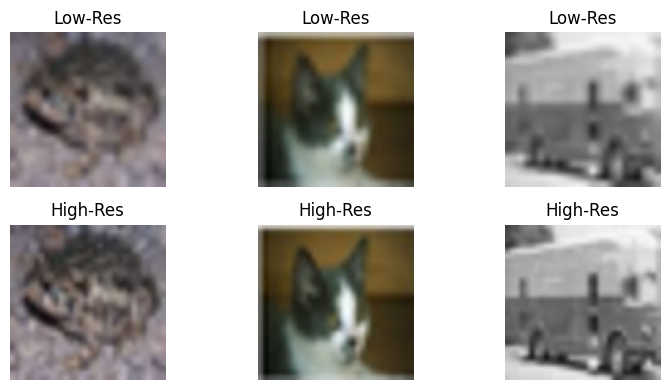

In [7]:
batch = next(iter(train_loader))
lr, hr = batch['lr'], batch['hr']

def show_image(tensor_img, title):
    img = tensor_img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    plt.imshow(np.clip(img, 0, 1))  # Clip values to be in range [0, 1]
    plt.title(title)
    plt.axis('off')

# Plot images in a grid
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    show_image(lr[i], "Low-Res")
    plt.subplot(2, 3, i + 4)
    show_image(hr[i], "High-Res")
plt.tight_layout()
plt.show()

## **SRGAN Architecture Overview**

SRGAN is composed of three key components working together to generate high-resolution images that are both accurate and perceptually convincing:

### 🧠 Generator – Super-Resolution Artist
The generator takes a low-resolution image and tries to reconstruct a high-resolution version with photorealistic textures. It typically consists of:

* Initial Convolution Block with ReLU activation
* Residual Blocks with skip connections (à la ResNet)
* Upsampling Layers (PixelShuffle or transposed conv) to scale up the image
* Final Conv Layer with tanh or sigmoid to produce output in [0, 1]

Goal: Fool the discriminator by generating images indistinguishable from real HR images.

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, num_residuals=16):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residuals = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residuals)]
        )
        self.conv_block = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.output = nn.Conv2d(64, 3, kernel_size=9, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        res = self.residuals(initial)
        conv = self.conv_block(res)
        up = self.upsample(initial + conv)
        return self.output(up)


### 🧐 Discriminator – Image Inspector
The discriminator is a CNN that receives either:

* a real high-resolution image or
* a generated high-resolution image

It learns to tell them apart. Architecturally, it’s a deep convolutional binary classifier, similar to PatchGAN in structure.
Goal: Accurately classify real vs fake images.



In [9]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def block(in_feat, out_feat, stride=1, bn=True):
            layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3, stride=stride, padding=1)]
            if bn:
                layers.append(nn.BatchNorm2d(out_feat))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(in_channels, 64, bn=False),
            *block(64, 64, stride=2),
            *block(64, 128),
            *block(128, 128, stride=2),
            *block(128, 256),
            *block(256, 256, stride=2),
            *block(256, 512),
            *block(512, 512, stride=2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


### 🎯Perceptual Loss – Seeing Like a Human
Instead of only using MSE between pixel values (which leads to blurry results), SRGAN incorporates perceptual loss using a pretrained VGG network:

* Extract feature maps from intermediate VGG layers (e.g., conv5_4)
* Compare these features between the generated and ground truth HR images
* This encourages the generator to preserve textures and structures humans notice

Total Generator Loss =  Pixel Loss (e.g., L1) +  Perceptual/VGG Loss + Adversarial Loss (read 03-Adversarial-loss.ipynb)

Training Loop Summary
At each step:

* Generator forward pass:  G(LR) → Super-resolved image
* Discriminator step:  Distinguish between G(LR) and real HR
* Compute Losses: Discriminator: real vs fake classification loss
* Generator: Content loss VGG (read 02-VGG-19.ipynb), Adversarial loss, Pixel-wise loss (read 05-PSNR.ipynb)
* Update weights: Step D optimizer, Step G optimizer

In [ ]:
from torchvision.models import vgg19
from torchvision.models.feature_extraction import create_feature_extractor

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights='VGG19_Weights.DEFAULT').features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:36]).eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.criterion = nn.MSELoss()

        # Normalization for ImageNet
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    def forward(self, fake, real):
        if fake.shape[1] == 1:  # if grayscale, repeat channels
            fake = fake.repeat(1, 3, 1, 1)
            real = real.repeat(1, 3, 1, 1)

        fake = (fake - self.mean.to(fake.device)) / self.std.to(fake.device)
        real = (real - self.mean.to(real.device)) / self.std.to(real.device)

        fake_feat = self.feature_extractor(fake)
        real_feat = self.feature_extractor(real)

        # Resize real_feat to match fake_feat
        real_feat_resized = torch.nn.functional.interpolate(real_feat, size=fake_feat.shape[2:], mode='bilinear', align_corners=False)

        return self.criterion(fake_feat, real_feat_resized)


## **Model Implementation**

Now, let's see how to put all of this together into a training step. Let's remember, we are building a special kind of training loop, an adversarial training. For this, what we requiere to do in every training step is:

Train the Discriminator:
* Get real HR image → label = 1
* Get Generator(LR image) = fake HR image → label = 0
* Compute binary cross-entropy loss
* Update Discriminator

Train the Generator:
* Generate HR image from LR input
* Compute: Adversarial loss (fool the discriminator → label = 1), Content loss (perceptual loss using VGG) and then combine them to compute Generator loss
* Update Generator

In [11]:
bce_loss = nn.BCELoss()
pixel_loss = nn.MSELoss()
perceptual_loss = PerceptualLoss()

def training_step( generator, discriminator, gen_optimizer, disc_optimizer, real_hr, lr_input,
                bce_loss, perceptual_loss, adv_weight=1e-3, content_weight=1.0, device=device):
    
    generator.train()
    discriminator.train()

    real_hr = real_hr.to(device)
    lr_input = lr_input.to(device)
    batch_size = real_hr.size(0)

    real_labels = torch.ones((batch_size, 1), device=device)
    fake_labels = torch.zeros((batch_size, 1), device=device)

    # Train Discriminator
    disc_optimizer.zero_grad()
    with torch.no_grad():
        fake_hr = generator(lr_input)
    pred_real = discriminator(real_hr)
    pred_fake = discriminator(fake_hr)
    d_loss_real = bce_loss(pred_real, real_labels)
    d_loss_fake = bce_loss(pred_fake, fake_labels)
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    disc_optimizer.step()

    # Train Generator
    gen_optimizer.zero_grad()
    fake_hr = generator(lr_input)
    pred_fake = discriminator(fake_hr)
    adversarial_loss = bce_loss(pred_fake, real_labels)
    content_loss = perceptual_loss(fake_hr, real_hr)
    g_loss = content_weight * content_loss + adv_weight * adversarial_loss
    g_loss.backward()
    gen_optimizer.step()

    return {
        'g_loss': g_loss.item(),
        'd_loss': d_loss.item(),
        'adv_loss': adversarial_loss.item(),
        'content_loss': content_loss.item()
    }


## **Training Loop**

With our training step function ready, we can build a simple training function

In [12]:
def train( generator, discriminator, dataloader, num_epochs=100, lr_gen=1e-4, lr_disc=1e-4, adv_weight=1e-3, content_weight=1.0,
            device=device, save_path='checkpoints', save_every=10):

    os.makedirs(save_path, exist_ok=True)

    generator.to(device)
    discriminator.to(device)

    gen_optimizer = optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_loss = nn.BCELoss()
    perceptual_loss = PerceptualLoss().to(device)

    for epoch in range(1, num_epochs + 1):
        epoch_losses = {
            'g_loss': 0.0,
            'd_loss': 0.0,
            'adv_loss': 0.0,
            'content_loss': 0.0
        }

        pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs}")
        for batch in pbar:
            lr_imgs, hr_imgs = batch['lr'], batch['hr']

            losses = training_step(
                generator, discriminator,
                gen_optimizer, disc_optimizer,
                hr_imgs, lr_imgs,
                bce_loss, perceptual_loss,
                adv_weight, content_weight,
                device
            )

            for key in epoch_losses:
                epoch_losses[key] += losses[key]
            pbar.set_postfix({k: f"{losses[k]:.4f}" for k in ['g_loss', 'd_loss']})

        num_batches = len(dataloader)
        avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}
        print(f"[Epoch {epoch}] G: {avg_losses['g_loss']:.4f} | D: {avg_losses['d_loss']:.4f} | Adv: {avg_losses['adv_loss']:.4f} | Content: {avg_losses['content_loss']:.4f}")

        if epoch % save_every == 0 or epoch == num_epochs:
            torch.save(generator.state_dict(), os.path.join(save_path, f'gen_epoch_{epoch}.pth'))
            torch.save(discriminator.state_dict(), os.path.join(save_path, f'disc_epoch_{epoch}.pth'))



With everything ready, we can run our adversarial training

In [ ]:
# Example: Create models and dataset loader
generator = Generator()
discriminator = Discriminator()
train_dataset = SRDataset(dataset=dataset)
# Your custom DataLoader that returns {'lr': ..., 'hr': ...}
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Train!
train(
    generator,
    discriminator,
    dataloader=train_loader,
    num_epochs=2,
    device=device
)


Epoch 1/2:   0%|          | 0/1563 [00:00<?, ?it/s]

fake_feat shape: torch.Size([32, 512, 24, 24])
real_feat shape: torch.Size([32, 512, 6, 6])


Epoch 1/2:   0%|          | 1/1563 [04:37<120:32:49, 277.83s/it, g_loss=0.3655, d_loss=1.3978]

fake_feat shape: torch.Size([32, 512, 24, 24])
real_feat shape: torch.Size([32, 512, 6, 6])


Epoch 1/2:   0%|          | 2/1563 [09:30<124:15:36, 286.57s/it, g_loss=0.3903, d_loss=1.3473]

fake_feat shape: torch.Size([32, 512, 24, 24])
real_feat shape: torch.Size([32, 512, 6, 6])


Epoch 1/2:   0%|          | 3/1563 [13:40<116:53:27, 269.75s/it, g_loss=0.3779, d_loss=1.3086]

fake_feat shape: torch.Size([32, 512, 24, 24])
real_feat shape: torch.Size([32, 512, 6, 6])


Epoch 1/2:   0%|          | 4/1563 [17:51<113:41:00, 262.51s/it, g_loss=0.3745, d_loss=1.2616]

And yes... The thing is that I'm doing this in my personal pc, so if I actually train the full model it probably would explode before even get to the first epoch haha. The important thing here is that you can actually see the training function working and training the model... So yeah, now you know how to train a SRGAN